# Predictive Maintenance Solutions
 - Machines need periodic maintenance for optimal performance
 - Too frequent maintenance lead to additional costs
 - Lack of timely maintenance leads to unexpected breakdowns and loss of profit


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [62]:
df = pd.read_csv("data/dataset.csv", index_col="UDI")
df.head()

,Product ID,Type,ATK,PTK,RPM,Torque,Wear,Failure
UDI,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0
3,L47182,L,298.1,308.5,1498,49.4,5,0
4,L47183,L,298.2,308.6,1433,39.5,7,0
5,L47184,L,298.2,308.7,1408,40.0,9,0


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ATK,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
PTK,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
RPM,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Wear,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
Failure,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0


In [64]:
df.describe(include="object").T

,count,unique,top,freq
Product ID,10000,10000,M14860,1
Type,10000,3,L,6000


In [65]:
counts = df['Failure'].value_counts()
counts

0    9661
1     339
Name: Failure, dtype: int64

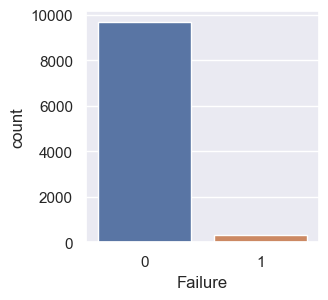

In [66]:
sns.set(rc={'figure.figsize':(3,3)})
sns.countplot(data=df, x='Failure')

In [67]:
df.Type.value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

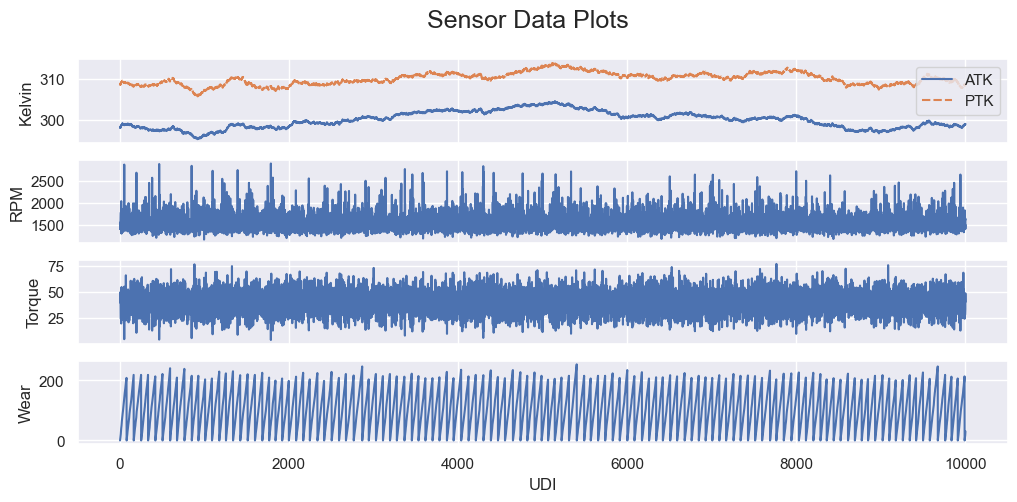

In [68]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
fig.suptitle('Sensor Data Plots', fontsize=18)

sns.lineplot(ax=axes[0], data=df[['ATK', 'PTK']])
axes[0].set_ylabel("Kelvin")
sns.lineplot(ax=axes[1], data=df['RPM'])
sns.lineplot(ax=axes[2], data=df['Torque'])
sns.lineplot(ax=axes[3], data=df['Wear'])

## Outliers Detection

In [69]:
num_features = ['ATK', 'PTK', 'RPM', 'Torque', 'Wear']
label = 'Failure'
X = df[num_features]
y = df[label]
X.shape

(10000, 5)

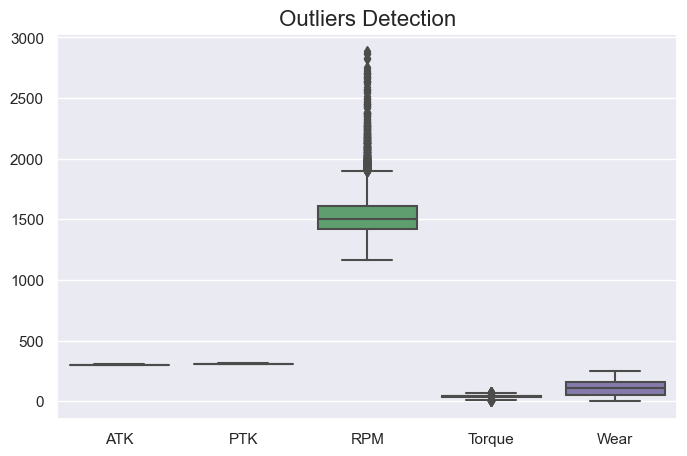

In [70]:
plt.subplots(figsize=(8, 5))
plt.title('Outliers Detection', fontsize=16)

sns.boxplot(data=X)

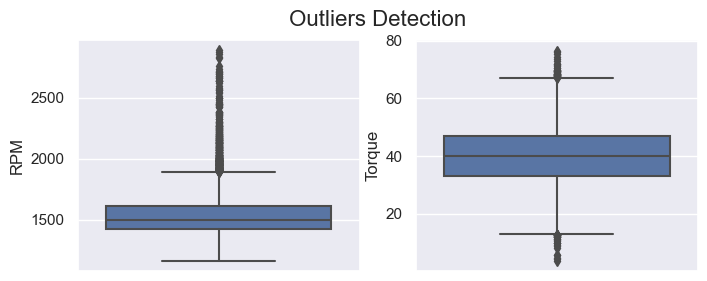

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Outliers Detection', fontsize=16)

sns.boxplot(ax=axes[0], y=X['RPM'])
sns.boxplot(ax=axes[1], y=X['Torque'])

In [72]:
X[['RPM']].describe().T

,count,mean,std,min,25%,50%,75%,max
RPM,10000.0,1538.7761,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0


In [73]:
# outlier detection
q1 = X['RPM'].quantile(0.25)
q3 = X['RPM'].quantile(0.75)
IQR = q3 - q1
low = q1 - 1.5*IQR
upp = q3 + 1.5*IQR

outliers = (X['RPM'] <= low) + (X['RPM'] >= upp)
n_outliers = len(X['RPM'][outliers])
p_outliers = 100*n_outliers/len(X)

print(f"{n_outliers} ({p_outliers:3.2f}%) Outliers")
print(f"Lower limit: {low}")
print(f"Upper limit: {upp}")

418 (4.18%) Outliers
Lower limit: 1139.5
Upper limit: 1895.5


In [74]:
# less than 5% outliers, so we will drop them keeping the failed instance
outliers_low = df['RPM'] <= low
outliers_upp = df['RPM'] >= upp

df['RPM'][(outliers_low | outliers_upp & df['Failure']==0)]

UDI
1        1551
2        1408
3        1498
4        1433
5        1408
         ... 
9996     1604
9997     1632
9998     1645
9999     1408
10000    1500
Name: RPM, Length: 9965, dtype: int64

In [75]:
df['RPM'][~(outliers_low | outliers_upp) | df['Failure']==1]

UDI
1        1551
2        1408
3        1498
4        1433
5        1408
         ... 
9996     1604
9997     1632
9998     1645
9999     1408
10000    1500
Name: RPM, Length: 9617, dtype: int64

In [76]:
df

,Product ID,Type,ATK,PTK,RPM,Torque,Wear,Failure
UDI,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0
3,L47182,L,298.1,308.5,1498,49.4,5,0
4,L47183,L,298.2,308.6,1433,39.5,7,0
5,L47184,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0
9997,H39410,H,298.9,308.4,1632,31.8,17,0
9998,M24857,M,299.0,308.6,1645,33.4,22,0


In [77]:
df = df[~(outliers_low | outliers_upp) | df['Failure']==1]
df

,Product ID,Type,ATK,PTK,RPM,Torque,Wear,Failure
UDI,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0
3,L47182,L,298.1,308.5,1498,49.4,5,0
4,L47183,L,298.2,308.6,1433,39.5,7,0
5,L47184,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0
9997,H39410,H,298.9,308.4,1632,31.8,17,0
9998,M24857,M,299.0,308.6,1645,33.4,22,0


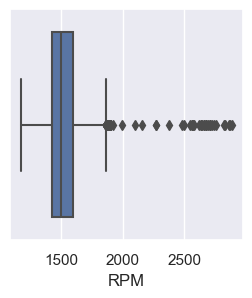

In [78]:
sns.boxplot(x=df['RPM'])


C:\Users\DAD\AppData\Local\Temp\ipykernel_12216\4223722467.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df['RPM'])


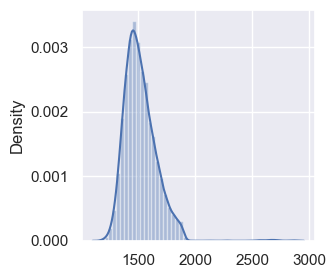

In [79]:
sns.distplot(x=df['RPM'])

In [80]:
num_features = ['ATK', 'PTK', 'RPM', 'Torque', 'Wear']
label = 'Failure'
X = df[num_features]
y = df[label]
print([X.shape, y.shape])
y.value_counts()

[(9617, 5), (9617,)]


0    9278
1     339
Name: Failure, dtype: int64

## Features Covaiance / Correlation

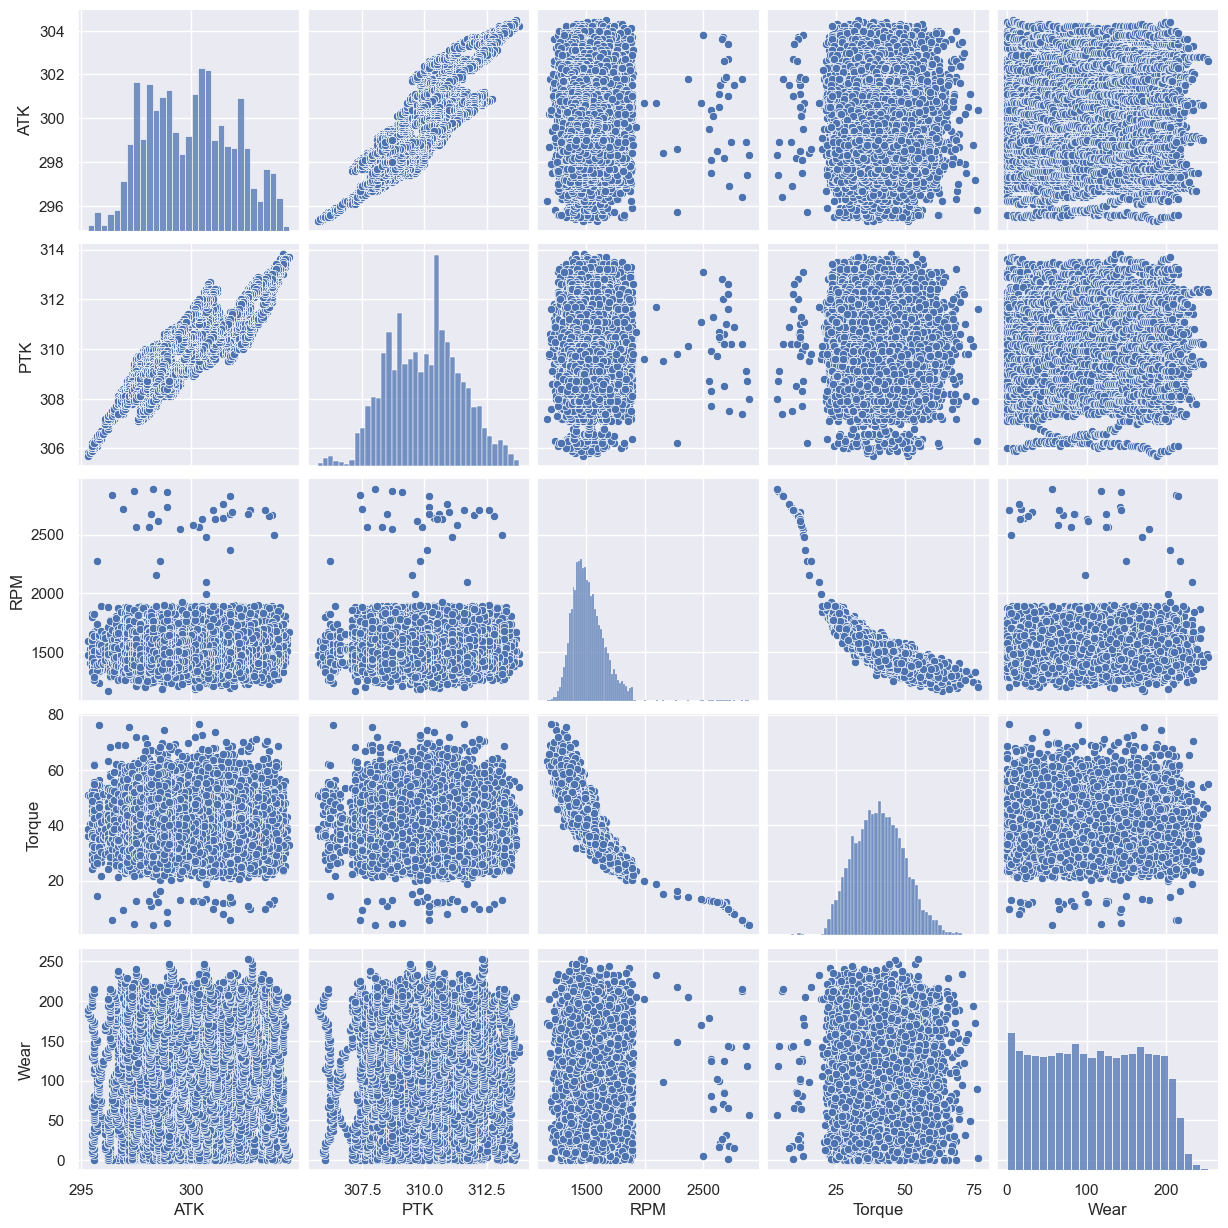

In [81]:
sns.pairplot(X)
plt.show()

In [82]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

C:\Users\DAD\AppData\Local\Temp\ipykernel_12216\3858386629.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,ATK,PTK,RPM,Torque,Wear
ATK,1.000,0.876,0.013,-0.005,0.015
PTK,0.876,1.000,0.014,-0.010,0.015
RPM,0.013,0.014,1.000,-0.867,0.004
Torque,-0.005,-0.010,-0.867,1.000,-0.006
Wear,0.015,0.015,0.004,-0.006,1.000


## Classification with different algorithms

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [84]:
y_train.shape

(7212,)

Text(0.5, 1.0, 'Test dataset')

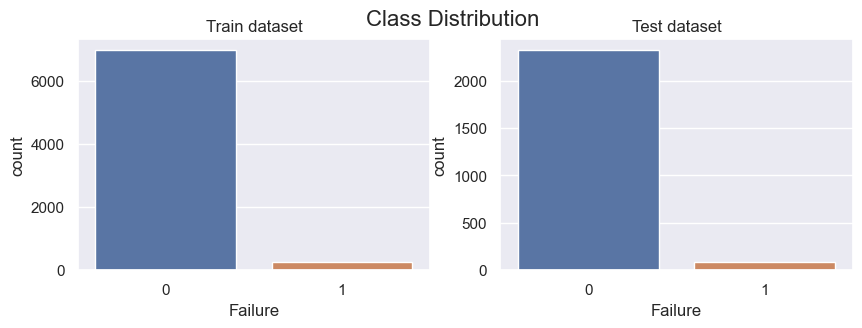

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Class Distribution', fontsize=16)

sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title("Train dataset")

sns.countplot(ax=axes[1], x=y_test)
axes[1].set_title("Test dataset")

In [86]:
# Logistic Regression Classifier

# logreg = LogisticRegression(C=1e5, random_state=0)
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train_transformed, y_train)
y_pred = logreg.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print("Accuracy: %5.4f" % (cross_val_score(logreg, X, y, cv=10).mean()))
# logreg

              precision    recall  f1-score   support

     class 0       0.97      1.00      0.98      2320
     class 1       0.77      0.24      0.36        85

    accuracy                           0.97      2405
   macro avg       0.87      0.62      0.67      2405
weighted avg       0.97      0.97      0.96      2405

[[2314    6]
 [  65   20]]
Area Under Curve: 0.6163539553752536


In [87]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_transformed, y_train)
y_pred = dt.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print("Accuracy: %5.4f" % (cross_val_score(dt, X, y, cv=10).mean()))
# dt

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      2320
     class 1       0.69      0.65      0.67        85

    accuracy                           0.98      2405
   macro avg       0.84      0.82      0.83      2405
weighted avg       0.98      0.98      0.98      2405

[[2295   25]
 [  30   55]]
Area Under Curve: 0.8181414807302231


In [88]:
# Random Forest Classifier

#rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print("Accuracy: %5.4f" % (cross_val_score(rf, X, y, cv=10).mean()))
# rf

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2320
     class 1       0.90      0.61      0.73        85

    accuracy                           0.98      2405
   macro avg       0.94      0.80      0.86      2405
weighted avg       0.98      0.98      0.98      2405

[[2314    6]
 [  33   52]]
Area Under Curve: 0.8045892494929007


In [89]:
# Adaboost Classifier

# ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train_transformed, y_train)
y_pred = ada.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print("Accuracy: %5.4f" % (cross_val_score(ada, X, y, cv=10).mean()))
# ada

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      2320
     class 1       0.68      0.38      0.48        85

    accuracy                           0.97      2405
   macro avg       0.83      0.69      0.74      2405
weighted avg       0.97      0.97      0.97      2405

[[2305   15]
 [  53   32]]
Area Under Curve: 0.6850025354969574


In [90]:
# Gradient Boosting Classifier

# gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbm = GradientBoostingClassifier(random_state=0)
gbm.fit(X_train_transformed, y_train)
y_pred = gbm.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print("Accuracy: %5.4f" % (cross_val_score(gbm, X, y, cv=10).mean()))
# gbm

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2320
     class 1       0.90      0.66      0.76        85

    accuracy                           0.99      2405
   macro avg       0.95      0.83      0.88      2405
weighted avg       0.98      0.99      0.98      2405

[[2314    6]
 [  29   56]]
Area Under Curve: 0.8281186612576065


In [91]:
# K-nearest neighbors classifier

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.98      2320
     class 1       0.61      0.48      0.54        85

    accuracy                           0.97      2405
   macro avg       0.80      0.74      0.76      2405
weighted avg       0.97      0.97      0.97      2405

[[2294   26]
 [  44   41]]
Area Under Curve: 0.7355730223123732


In [92]:
# Weighted Logistic Regression Classifier

# logreg = LogisticRegression(C=1e5, random_state=0)
logreg_w = LogisticRegression(class_weight='balanced', random_state=0)
logreg_w.fit(X_train_transformed, y_train)
y_pred = logreg_w.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.99      0.83      0.90      2320
     class 1       0.14      0.78      0.24        85

    accuracy                           0.83      2405
   macro avg       0.57      0.80      0.57      2405
weighted avg       0.96      0.83      0.88      2405

[[1920  400]
 [  19   66]]
Area Under Curve: 0.8020283975659228


In [93]:
# XGBoost
from xgboost import XGBClassifier

# evaluate the model
xgb = XGBClassifier()
xgb.fit(X_train_transformed, y_train)
y_pred = xgb.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2320
     class 1       0.90      0.67      0.77        85

    accuracy                           0.99      2405
   macro avg       0.95      0.83      0.88      2405
weighted avg       0.99      0.99      0.98      2405

[[2314    6]
 [  28   57]]
Area Under Curve: 0.8340010141987828


[0.19727659 0.16281074 0.22321622 0.22931473 0.18738174]


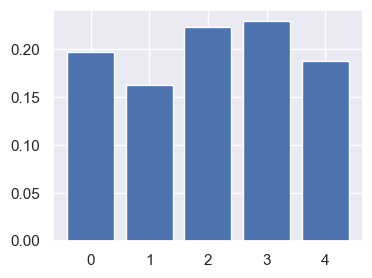

In [94]:
# Manually plot XGBoost feature importance
print(xgb.feature_importances_)
# plot
plt.figure(figsize=(4,3))
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

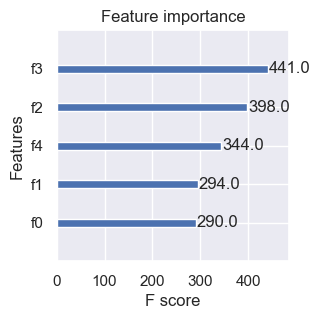

In [95]:
# plot feature importance using built-in xgboost functionality 
from xgboost import plot_importance
plot_importance(xgb)
plt.show()

In [96]:
# LightGBM
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_transformed, y_train)
y_pred = lgbm.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2320
     class 1       0.93      0.64      0.76        85

    accuracy                           0.99      2405
   macro avg       0.96      0.82      0.87      2405
weighted avg       0.98      0.99      0.98      2405

[[2316    4]
 [  31   54]]
Area Under Curve: 0.8167849898580122


In [97]:
#CatBoost
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(X_train_transformed, y_train, verbose=False)

In [98]:
y_pred = cat.predict(X_test_transformed)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2320
     class 1       0.90      0.67      0.77        85

    accuracy                           0.99      2405
   macro avg       0.95      0.83      0.88      2405
weighted avg       0.99      0.99      0.98      2405

[[2314    6]
 [  28   57]]
Area Under Curve: 0.8340010141987828


### Classifier performance comparison
 - Decision tree, random forest and weighted logistic regression classifiers performed the same with ROC-ACU around 0.8.
 - Gradient boosted ensembles performed better with XGBoost & CatBoost tied at ROC-AUC of 0.834


### Hyperparameter Tuning

In [99]:
import numpy as np
train = pd.DataFrame(X_train_transformed, columns=num_features)
#train['target'] = y_train
print(train.shape, X_train_transformed.shape, y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)
train.isnull().sum()

(7212, 5) (7212, 5) (7212,)
[[   0 6958]
 [   1  254]]


ATK       0
PTK       0
RPM       0
Torque    0
Wear      0
dtype: int64

In [100]:
# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define model
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.979500 using {'scale_pos_weight': 10}
0.979177 (0.009722) with: {'scale_pos_weight': 1}
0.979500 (0.009473) with: {'scale_pos_weight': 10}
0.977296 (0.012006) with: {'scale_pos_weight': 25}
0.977085 (0.010636) with: {'scale_pos_weight': 50}
0.975748 (0.012520) with: {'scale_pos_weight': 75}
0.976865 (0.009987) with: {'scale_pos_weight': 99}
0.977097 (0.011463) with: {'scale_pos_weight': 100}
0.968677 (0.017062) with: {'scale_pos_weight': 1000}


In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:

predictors = num_features
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)